<a href="https://colab.research.google.com/github/calamistratus/Dirty-plate-classification/blob/main/Neural-Network-building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision

from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [128]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [129]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(150),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(360),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.ColorJitter(*[.5 for _ in range (4)]),
    torchvision.transforms.GaussianBlur(1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] )
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((150, 150)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] )
])

In [130]:
path = '/content/drive/MyDrive/plates/'

train_df = torchvision.datasets.ImageFolder(path + 'plates/' + 'train', train_transforms)
val_df = torchvision.datasets.ImageFolder(path + 'plates/' + 'test', val_transforms)

In [131]:
batch_size = 40

train_dataloader = torch.utils.data.DataLoader(train_df, batch_size, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_df, batch_size, shuffle=False, num_workers=2)

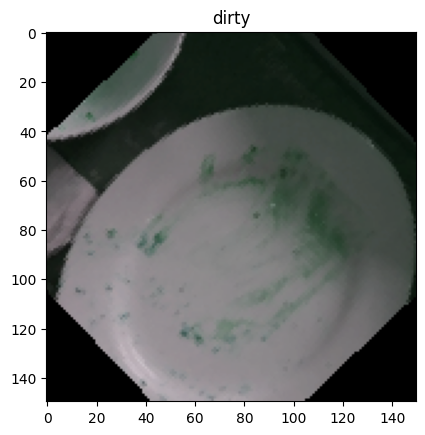

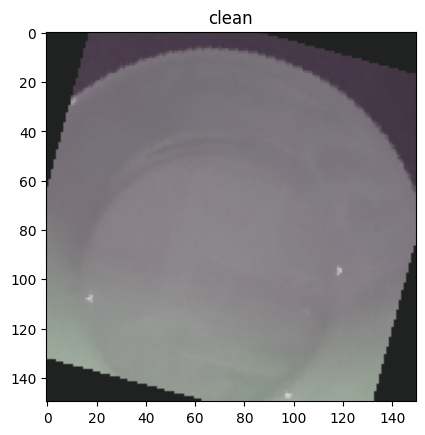

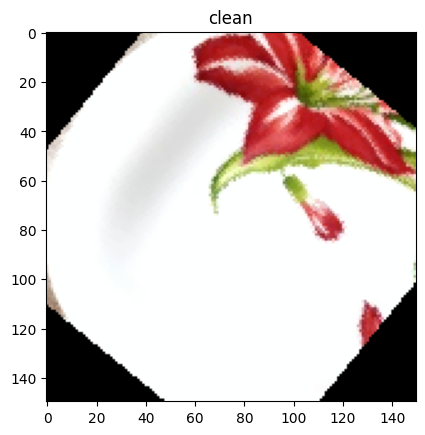

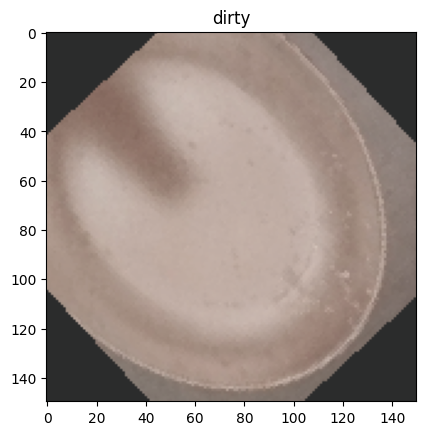

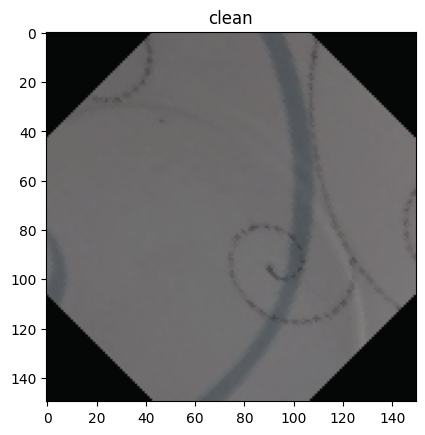

In [132]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
for i in range(5):
  plt.imshow((X_batch[i].permute(1, 2, 0).numpy() * std + mean).clip(0, 1))
  plt.title(['clean', 'dirty'][y_batch[i]])
  plt.show()

In [133]:
model = torchvision.models.resnet152(weights=torchvision.models.ResNet152_Weights.DEFAULT)
clear_output()

for param in model.parameters():
  param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), .001)

In [134]:
def train(model, optimizer, loss, epochs):
  model.to(device)
  metrics = [[], []]
  for epoch in range(epochs):
    model.train()
    dataloader = train_dataloader

    running_loss = 0.
    running_acc = 0.

    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      preds = model.forward(inputs)
      loss_value = loss(preds, labels)
      preds_class = preds.argmax(dim=1)

      loss_value.backward()

      optimizer.step()

      running_loss += loss_value.item()
      running_acc += (preds_class == labels).float().mean()

    epoch_loss = running_loss / len(dataloader)

    metrics[0].append(running_loss)

    epoch_acc = running_acc / len(dataloader)

    metrics[1].append(epoch_acc.item())

    print('Epoch number', epoch, '\n', 'Loss:', epoch_loss, 'Acc:', epoch_acc.item())

    if (epoch - 1) % 10 == 0:
      clear_output()

  return metrics

In [135]:
metrics = train(model, optimizer, loss, 1000)

Epoch number 992 
 Loss: 0.13662701845169067 Acc: 0.925000011920929
Epoch number 993 
 Loss: 0.10790089517831802 Acc: 0.9750000238418579
Epoch number 994 
 Loss: 0.16402825713157654 Acc: 0.949999988079071
Epoch number 995 
 Loss: 0.19383536279201508 Acc: 0.949999988079071
Epoch number 996 
 Loss: 0.13110403716564178 Acc: 0.949999988079071
Epoch number 997 
 Loss: 0.15380974113941193 Acc: 0.9000000357627869
Epoch number 998 
 Loss: 0.12398780882358551 Acc: 0.9000000357627869
Epoch number 999 
 Loss: 0.14557793736457825 Acc: 0.949999988079071


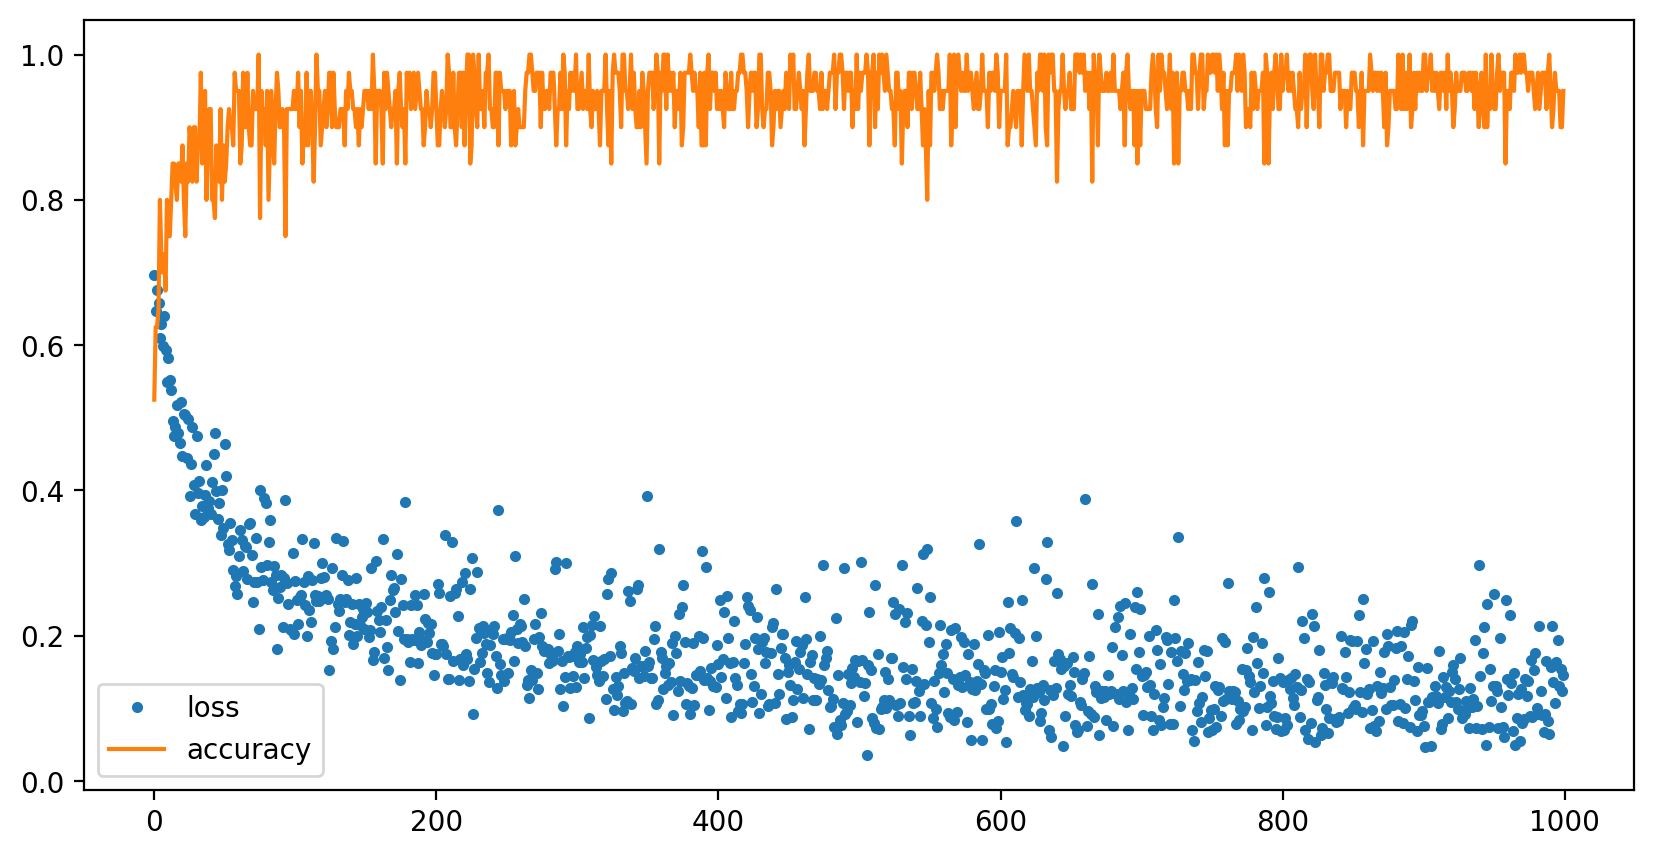

In [136]:
nrange = range(1000)
plt.figure(dpi=200, figsize=(10, 5))
plt.plot(nrange, metrics[0], '.', linewidth=.5)
plt.plot(nrange, metrics[1])
plt.legend(['loss', 'accuracy'])
plt.show()

In [137]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

test_dataset = ImageFolderWithPaths(path + 'plates/' + 'test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [138]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)

test_predictions = np.concatenate(test_predictions)

100%|██████████| 19/19 [00:09<00:00,  2.08it/s]


In [140]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
submission_df['id'] = submission_df['id'].apply(lambda name : int(name[name.rfind('/') + 1: name.find('.')]))
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df.set_index('id', inplace=True)

submission_df.to_csv('sub.csv')